In [16]:
import sys
import torch  
import numpy as np  
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from torch.distributions.categorical import Categorical
import math
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from preprocess import mean, std, preprocess_input_function
from settings import train_dir, test_dir, train_push_dir, train_batch_size, test_batch_size, train_push_batch_size
from settings import base_architecture, img_size, prototype_shape, num_classes, prototype_activation_function, add_on_layers_type
from receptive_field import compute_rf_prototype
import cv2
#from reward_model import construct_PrefNet, paired_cross_entropy_loss, PrefNet
from tqdm import tqdm
from settings import joint_optimizer_lrs, joint_lr_step_size
import skimage as sk
import skimage.io as skio
import train_and_test as tnt
from torch.utils.data import Subset
import time
import heapq
import model

In [17]:
'''
Use PPnet's forward pass as the policy network (actor network); what about the network for value function (critic network)?
Since there are only determinant actions, this is essentially A2C...
'''
class A3C_PPnet(nn.Module):
    def __init__(self, PPnet, preference_model, k=1, p=5, learning_rate=1e-4, dummy_reward=False, train_batch_size=80):
        super(A3C_PPnet, self).__init__()
        
        
        self.PPnet = PPnet.cuda()
        self.k = k
        self.pf_model = preference_model.cuda()
        
        self.PPnet_multi = self.PPnet
        for p in self.PPnet_multi.module.features.parameters():
            p.requires_grad = False
        for p in self.PPnet_multi.module.add_on_layers.parameters():
            p.requires_grad = False
        self.PPnet_multi.module.prototype_vectors.requires_grad = True
        for p in self.PPnet_multi.module.last_layer.parameters():
            p.requires_grad = False
        
        self.train_batch_size = train_batch_size
        self.num_epoch = 0
        policy_optimizer_specs = [#{'params': self.PPnet.features.parameters(), 'lr': joint_optimizer_lrs['features'], 'weight_decay': 1e-3}, 
                                  #{'params': self.PPnet.add_on_layers.parameters(), 'lr': joint_optimizer_lrs['add_on_layers'], 'weight_decay': 1e-3},
                                  #{'params': self.PPnet.prototype_vectors, 'lr': joint_optimizer_lrs['prototype_vectors']},
                                  #{'params': self.PPnet.module.add_on_layers.parameters(), 'lr': 1e-4, 'weight_decay': 1e-5},
                                  {'params': self.PPnet.module.prototype_vectors, 'lr': 1e-3, 'weight_decay': 1e-4}
                                  ]
        self.policy_optimizer = torch.optim.Adam(policy_optimizer_specs)
        self.num_iteration = 0
        
        
    def get_heatmaps(self, batch_x, labels, pid):
        self.PPnet_multi.eval()
        n_prototypes = self.PPnet_multi.module.num_prototypes
        prototype_shape = self.PPnet_multi.module.prototype_shape
        max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]
        protoL_rf_info = self.PPnet_multi.module.proto_layer_rf_info
        
        batch_x = batch_x.cuda()
        protoL_input_torch, proto_dist_torch = self.PPnet_multi.module.push_forward(batch_x)
        
        proto_dist_ = proto_dist_torch.view(proto_dist_torch.shape[0], proto_dist_torch.shape[1], -1)
        # proto_dist_: (batch_size, 1000, 49)
        all_distances = torch.amin(proto_dist_, axis=-1)
        # all_distances: (batch_size, 1000)
        target_p = [pid]
        #for i in range(all_distances.shape[1]):
        #    class_i = torch.argmax(self.PPnet_multi.module.prototype_class_identity[i])
        #    if class_i == class_identity:
        #        target_p.append(i)
        
        proto_dist = torch.clone(proto_dist_torch)
       
        proto_dist = torch.transpose(proto_dist, 0, 1)
        dists = all_distances[:, target_p]
        dists = torch.transpose(dists, 0, 1)
        
    
        # proto_dist: (1000, batch_size)
        proto_dist_numpy = proto_dist.detach().cpu().numpy()
        
        
        original_imgs = []
        rescaled_patterns = []
        
        for j in target_p:
            
            original_imgs_j = []
            rescaled_patterns_j = []
           
            for i in range(len(batch_x)):
                closest_patch_indices_in_distance_map_j = list(np.unravel_index(np.argmin(proto_dist_numpy[j][i],axis=None), proto_dist_numpy[j][i].shape))
                closest_patch_indices_in_distance_map_j = [0] + closest_patch_indices_in_distance_map_j
                
                closest_patch_indices_in_img = compute_rf_prototype(batch_x.size(2), closest_patch_indices_in_distance_map_j, protoL_rf_info)
                closest_patch = \
                    batch_x[i, :, closest_patch_indices_in_img[1]:closest_patch_indices_in_img[2], closest_patch_indices_in_img[3]:closest_patch_indices_in_img[4]]
                closest_patch = closest_patch.cpu().numpy()
                closest_patch = np.transpose(closest_patch, (1, 2, 0))

                original_img = batch_x[i].cpu().numpy()
                original_img = np.transpose(original_img, (1, 2, 0))
                
                
                if self.PPnet_multi.module.prototype_activation_function == 'log':
                    act_pattern = np.log((proto_dist_numpy[j][i] + 1)/(proto_dist_numpy[j][i] + self.PPnet_multi.module.epsilon))
                elif self.PPnet_multi.module.prototype_activation_function == 'linear':
                    act_pattern = max_dist - proto_dist_numpy[j][i]
                else:
                    act_pattern = prototype_activation_function_in_numpy(proto_dist_numpy[j][i])

                patch_indices = closest_patch_indices_in_img[1:5]
                          
                upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
                rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
                rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
                
                original_img = original_img - np.amin(original_img)
                original_img = original_img / np.amax(original_img)
                original_imgs_j.append(original_img)
                rescaled_patterns_j.append(rescaled_act_pattern)
                
            
            original_imgs.append(original_imgs_j)
            rescaled_patterns.append(rescaled_patterns_j)
    
        return original_imgs, rescaled_patterns, dists
    
    '''
    imgs: (1000, 1, 224, 224, 3), patterns: (1000, 1, 224, 224)
    '''
    def get_rewards(self, imgs, patterns):
        
        num_p = len(imgs)
        assert num_p == len(patterns)
        batch_size = len(imgs[0])
        assert batch_size == len(patterns[0])
        
        with torch.no_grad():
            rewards = torch.empty((num_p, batch_size))
            for i in range(num_p):
                for j in range(batch_size):
                    img = np.array([imgs[i][j]])
                    img = np.transpose(img, (0, 3, 1, 2))
                    img = torch.from_numpy(img).cuda()
                
                    pattern = patterns[i][j]
                    pattern = np.array([pattern, pattern, pattern])
                    pattern = torch.from_numpy(np.array([pattern])).cuda()
                    reward = self.pf_model(img, pattern) 
                    rewards[i][j] = reward
                
        return rewards
        
    def joint_update(self, rewards, dists):
        #print(dists)
        
        assert rewards.shape[0] == len(dists)
        assert rewards.shape[1] == len(dists[0])
        
        self.policy_optimizer.zero_grad()
        loss = 0
        for i in range(rewards.shape[0]):
            for j in range(rewards.shape[1]):
                if dists[i][j] > 0:
                    loss -= (1 / (100*dists[i][j]+1)) * rewards[i][j]
                #elif dists[i][j] == 0:
                #    loss -= rewards[i][j]
        
        loss.backward()
        self.policy_optimizer.step()
        return 
    
    
    def run(self, batch_x, labels, pid, update=True):

        original_imgs, rescaled_patterns, dists = self.get_heatmaps(batch_x, labels, pid)
        rewards = self.get_rewards(original_imgs, rescaled_patterns)
        if update:
            loss = self.joint_update(rewards, dists)
        
        
        
        return torch.mean(rewards)
   
    

In [18]:
from resnet_features import resnet18_features, resnet34_features, resnet50_features, resnet101_features, resnet152_features
from densenet_features import densenet121_features, densenet161_features, densenet169_features, densenet201_features
from vgg_features import vgg11_features, vgg11_bn_features, vgg13_features, vgg13_bn_features, vgg16_features, vgg16_bn_features,\
                         vgg19_features, vgg19_bn_features
from receptive_field import compute_proto_layer_rf_info_v2
base_architecture_to_features = {'resnet18': resnet18_features,
                                 'resnet34': resnet34_features,
                                 'resnet50': resnet50_features,
                                 'resnet101': resnet101_features,
                                 'resnet152': resnet152_features,
                                 'densenet121': densenet121_features,
                                 'densenet161': densenet161_features,
                                 'densenet169': densenet169_features,
                                 'densenet201': densenet201_features,
                                 'vgg11': vgg11_features,
                                 'vgg11_bn': vgg11_bn_features,
                                 'vgg13': vgg13_features,
                                 'vgg13_bn': vgg13_bn_features,
                                 'vgg16': vgg16_features,
                                 'vgg16_bn': vgg16_bn_features,
                                 'vgg19': vgg19_features,
                                 'vgg19_bn': vgg19_bn_features}


class PrefNet(nn.Module):

    def __init__(self, img_features, pattern_features, img_size, prototype_shape,
                 proto_layer_rf_info, num_classes, init_weights=False,
                 prototype_activation_function='log',
                 add_on_layers_type='bottleneck', 
                k = 1):

        super(PrefNet, self).__init__()
        self.img_size = img_size
        self.prototype_shape = prototype_shape
        self.num_prototypes = prototype_shape[0]
        self.num_classes = num_classes
        self.epsilon = 1e-4
        self.k = k
        
        # this has to be named features to allow the precise loading
        self.img_features = img_features
        self.pattern_features = pattern_features
        
                
#         self.prototype_vectors = nn.Parameter(torch.rand(self.prototype_shape),
#                                               requires_grad=True)

#         # do not make this just a tensor,
#         # since it will not be moved automatically to gpu
#         self.ones = nn.Parameter(torch.ones(self.prototype_shape),
#                                  requires_grad=False)

#         self.last_layer = nn.Linear(self.num_prototypes, self.num_classes,
#                                     bias=False) # do not use bias
    

        self.img_conv = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3),
            nn.Sigmoid()
            )
        
        self.pattern_conv = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3),
            nn.Sigmoid()
            )
        
        self.final_fc = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Sigmoid(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        
            )
        
        #self.fc1 = nn.Linear(6400, 512)
        #self.fc2 = nn.Linear(512, 32)
        #self.fc3 = nn.Linear(32, 1)
        #self.fc1 = nn.Linear(64, 16)
        

        if init_weights:
            self._initialize_weights()
            
            
    def conv_features(self, x):
        '''
        the feature input to prototype layer
        '''
        # Insert k and then img size
        x = self.features(x)
        #print("base features: ", x.shape)
        #x = self.add_on_layers(x)
        return x
    
    def forward(self, x, p):
        # (N, 512, 7, 7)
        #x = self.conv_features(x)
        x = self.img_features(x)
        #x = self.add_on_layers(x)
        x = self.img_conv(x)
        #print("conv out:", x.shape)
        p = self.pattern_features(p)
        #p = self.conv_features(p)
        #p = self.add_on_layers(p)
        p = self.pattern_conv(p)
        
        out = torch.cat((x, p), dim=1)
        #print("cat out shape: ", out.shape)
        out = torch.flatten(out, 1) 
        #print("flatten out shape: ", out.shape)
        
        out = self.final_fc(out)
        #out = torch.sigmoid(self.fc1(out))
        #out = torch.sigmoid(self.fc2(out))
        #out = self.fc3(out)
        return out

    
    def _initialize_weights(self):
        for m in self.img_conv.modules():
            if isinstance(m, nn.Conv2d):
                # every init technique has an underscore _ in the name
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        for m in self.pattern_conv.modules():
            if isinstance(m, nn.Conv2d):
                # every init technique has an underscore _ in the name
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)




            
def construct_PrefNet(base_architecture, pretrained=True, img_size=224,
                    prototype_shape=(1000, 128, 1, 1), num_classes=200,
                    prototype_activation_function='log',
                    add_on_layers_type='bottleneck',
                    k = 1):
    img_features = base_architecture_to_features[base_architecture](pretrained=pretrained)
    pattern_features = base_architecture_to_features[base_architecture](pretrained=pretrained)
    layer_filter_sizes, layer_strides, layer_paddings = img_features.conv_info()
    proto_layer_rf_info = compute_proto_layer_rf_info_v2(img_size=img_size,
                                                         layer_filter_sizes=layer_filter_sizes,
                                                         layer_strides=layer_strides,
                                                         layer_paddings=layer_paddings,
                                                         prototype_kernel_size=prototype_shape[2])
    return PrefNet(img_features=img_features,
                   pattern_features=pattern_features,
                 img_size=img_size,
                 prototype_shape=prototype_shape,
                 proto_layer_rf_info=proto_layer_rf_info,
                 num_classes=num_classes,
                 init_weights=True,
                 prototype_activation_function=prototype_activation_function,
                 add_on_layers_type=add_on_layers_type,
                 k = k)


def paired_cross_entropy_loss(out1, out2, targets):
    
    total_loss = 0
    for i in range(len(targets)):
        
        if targets[i] == -1:
            p1 = torch.exp(out1[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - torch.log(p1)
        elif targets[i] == 1:
            p2 = torch.exp(out2[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - torch.log(p2)

        else:
            p1 = torch.exp(out1[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            p2 = torch.exp(out2[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - (0.5*torch.log(p1) + 0.5*torch.log(p2))
            
        total_loss += loss
    return total_loss


In [19]:
#ppnet = torch.load(r'../saved_models/vgg19/004/100_7push0.7344.pth')
ppnet = torch.load(r'./A3C_results/joint_resnet34_005.pth')
ppnet = torch.nn.DataParallel(ppnet)
pf_model = torch.load('./human_comparisons/pref_model_700_random_rating_split0.7_acc0.915.pth')

In [20]:
normalize = transforms.Normalize(mean=mean, std=std)

train_dataset = datasets.ImageFolder(
        train_push_dir,
        transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=80, shuffle=False,
    num_workers=2, pin_memory=False)

test_dataset = datasets.ImageFolder(
        test_dir,
        transforms.Compose([
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False,
    num_workers=2, pin_memory=False)


#shuffled_dataset = Subset(train_dataset, shuffled_indices)

In [21]:
def evaluate_avg_rewards(a3c):
    rewards = []
    for p_idx in tqdm(range(2000)):
        if p_idx % 10 == 0:
            class_idx = p_idx // 10
            class_imgs = [x for x, y in enumerate(test_dataset.targets) if y == class_idx]
            class_dataset = Subset(test_dataset, class_imgs)
            dataloader = torch.utils.data.DataLoader(class_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=False)
            batch, label = next(iter(dataloader))
        with torch.no_grad():
            best_reward = a3c.run(batch, label, p_idx, update=False)
        rewards.append(best_reward)
    return rewards

In [22]:
a3c = A3C_PPnet(ppnet, pf_model)
rewards = evaluate_avg_rewards(a3c)

100%|██████████| 2000/2000 [15:27<00:00,  2.16it/s]


In [23]:
np.mean(np.array(rewards))

0.57091695

In [25]:
np.save('./figures/prototype_rewards_reselect_resnet_test', rewards)

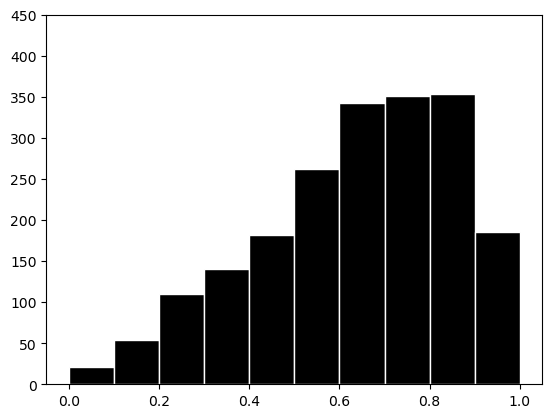

In [31]:
rewards_new = np.load('./figures/prototype_rewards_joint_vgg_10_test.npy')
plt.hist(rewards_new, np.linspace(0, 1, num=11), color = "black", ec="white")
plt.ylim([0, 450])
plt.savefig('./figures/test_reward_hist_vgg_10_joint.pdf', format='pdf', bbox_inches='tight')

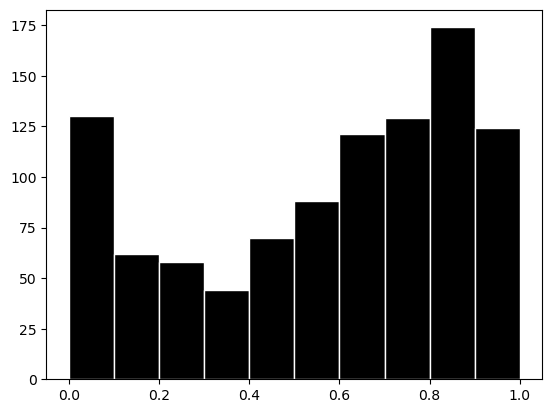

In [39]:
rewards_old = np.load('./figures/prototype_rewards_ppnet_vgg_5_0.7344.npy')
plt.hist(rewards_old, np.linspace(0, 1, num=11), color = "black", ec="white")
#plt.savefig('./figures/reward_hist_vgg_5_ppnet.png', bbox_inches='tight')

In [13]:
np.mean(np.array(rewards))

0.67571527

In [12]:
rewards_1 = np.load('./figures/prototype_rewards_joint_vgg_5_0.7411.npy')
np.mean(rewards_1)

0.68316084

In [21]:
rewards_1_updated = np.load('./figures/prototype_rewards_joint_vgg_5_0.7411.npy')
np.mean(rewards_1_updated)

0.68316084

In [6]:

ppnet = torch.load(r'./A3C_results/joint_003_reselect_1000.pth')
ppnet_multi = torch.nn.DataParallel(ppnet)
acc = tnt.test(model=ppnet_multi, dataloader=test_loader, class_specific=True, log=print)

	test


58it [00:24,  2.40it/s]


	time: 	24.293993949890137
	cross ent: 	1.5754019689971004
	cluster: 	0.04503387235233496
	separation:	0.03591254013108796
	avg separation:	1.035600067212664
	accu: 		70.31411805315844%
	l1: 		1273.353515625
	p dist pair: 	2.1466312408447266
